In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Exercise 9.

In [2]:
(x_train_full, y_train_full), (x_test, y_test) = keras.datasets.cifar10.load_data()

x_train_full = x_train_full / 255
x_test = x_test / 255

x_train, x_valid = x_train_full[5000:], x_train_full[:5000]
y_train, y_valid = y_train_full[5000:], y_train_full[:5000]

In [3]:
x_train.shape

(45000, 32, 32, 3)

In [4]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))


def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')
    
    
def show_reconstructions(model, images=x_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [5]:
denoising_encoder = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.MaxPool2D(),    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
])

denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(16 * 16 * 32, activation='selu', 
                       input_shape=[512]),
    keras.layers.Reshape([16, 16, 32]),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=2, 
                                 padding='same', activation='sigmoid')
])

denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss='binary_crossentropy',
                     optimizer=keras.optimizers.SGD(learning_rate=1.0), 
                     metrics=[rounded_accuracy])

In [6]:
denoising_encoder.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise (GaussianNois (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 4096)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               2

In [7]:
denoising_decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 8192)              4202496   
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 3)         867       
Total params: 4,203,363
Trainable params: 4,203,363
Non-trainable params: 0
_________________________________________________________________


In [8]:
denoising_ae.fit(x_train, x_train, epochs=20, 
                 validation_data=(x_valid, x_valid))

Epoch 1/20
1407/1407 [==============================] - 14s 9ms/step - loss: 0.6332 - rounded_accuracy: 0.7355 - val_loss: 0.5971 - val_rounded_accuracy: 0.8238
Epoch 2/20
1407/1407 [==============================] - 33s 23ms/step - loss: 0.5906 - rounded_accuracy: 0.8417 - val_loss: 0.5814 - val_rounded_accuracy: 0.8600
Epoch 3/20
1407/1407 [==============================] - 90s 64ms/step - loss: 0.5795 - rounded_accuracy: 0.8659 - val_loss: 0.5954 - val_rounded_accuracy: 0.8131
Epoch 4/20
1407/1407 [==============================] - 12s 8ms/step - loss: 0.5750 - rounded_accuracy: 0.8758 - val_loss: 0.5711 - val_rounded_accuracy: 0.8837
Epoch 5/20
1407/1407 [==============================] - 10s 7ms/step - loss: 0.5725 - rounded_accuracy: 0.8821 - val_loss: 0.5711 - val_rounded_accuracy: 0.8819
Epoch 6/20
1407/1407 [==============================] - 10s 7ms/step - loss: 0.5708 - rounded_accuracy: 0.8862 - val_loss: 0.5685 - val_rounded_accuracy: 0.8895
Epoch 7/20
1407/1407 [==========

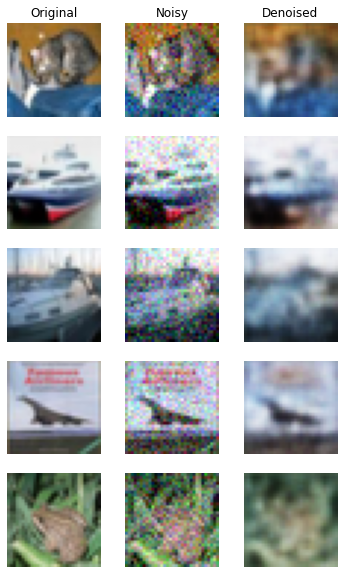

In [9]:
n_images = 5
new_images = x_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoising_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()

In [10]:
from tensorflow.keras.utils import to_categorical

y_train_one_hot = to_categorical(y_train)
y_valid_one_hot = to_categorical(y_valid)
y_test_one_hot = to_categorical(y_test)

x_train_small, y_train_small = x_train[:500], y_train_one_hot[:500]

In [11]:
y_train_small[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [12]:
cls = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.MaxPool2D(),    
    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
])

In [13]:
weights = denoising_encoder.get_weights()
cls.set_weights(weights)

In [14]:
cls.pop()

for layer in cls.layers:
    layer.trainable = False

cls.add(keras.layers.Dense(10, activation='softmax'))
cls.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gaussian_noise_1 (GaussianNo (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)               

In [15]:
cls.compile(loss='categorical_crossentropy', 
            optimizer=keras.optimizers.Adam(), 
            metrics=['acc'])

cls.fit(x_train_small, y_train_small, epochs=15)

Epoch 1/15
16/16 [==============================] - 1s 20ms/step - loss: 2.3872 - acc: 0.1520
Epoch 2/15
16/16 [==============================] - 0s 4ms/step - loss: 1.8501 - acc: 0.3360
Epoch 3/15
16/16 [==============================] - 0s 3ms/step - loss: 1.6791 - acc: 0.4000
Epoch 4/15
16/16 [==============================] - 0s 3ms/step - loss: 1.4394 - acc: 0.5320
Epoch 5/15
16/16 [==============================] - 0s 3ms/step - loss: 1.3103 - acc: 0.6060
Epoch 6/15
16/16 [==============================] - 0s 3ms/step - loss: 1.2389 - acc: 0.6100
Epoch 7/15
16/16 [==============================] - 0s 4ms/step - loss: 1.1911 - acc: 0.6260
Epoch 8/15
16/16 [==============================] - 0s 4ms/step - loss: 1.0772 - acc: 0.6680
Epoch 9/15
16/16 [==============================] - 0s 3ms/step - loss: 0.9908 - acc: 0.7100
Epoch 10/15
16/16 [==============================] - 0s 3ms/step - loss: 0.9442 - acc: 0.7500
Epoch 11/15
16/16 [==============================] - 0s 3ms/step - l

In [16]:
for layer in cls.layers:
    layer.trainable = True

In [17]:
cls.fit(x_train_small, y_train_small, epochs=15)

Epoch 1/15
16/16 [==============================] - 0s 4ms/step - loss: 0.6684 - acc: 0.8720
Epoch 2/15
16/16 [==============================] - 0s 3ms/step - loss: 0.6481 - acc: 0.8600
Epoch 3/15
16/16 [==============================] - 0s 3ms/step - loss: 0.6291 - acc: 0.8580
Epoch 4/15
16/16 [==============================] - 0s 3ms/step - loss: 0.5740 - acc: 0.8900
Epoch 5/15
16/16 [==============================] - 0s 3ms/step - loss: 0.5595 - acc: 0.8960
Epoch 6/15
16/16 [==============================] - 0s 4ms/step - loss: 0.5288 - acc: 0.9040
Epoch 7/15
16/16 [==============================] - 0s 4ms/step - loss: 0.5320 - acc: 0.9160
Epoch 8/15
16/16 [==============================] - 0s 3ms/step - loss: 0.5047 - acc: 0.9080
Epoch 9/15
16/16 [==============================] - 0s 3ms/step - loss: 0.4738 - acc: 0.9140
Epoch 10/15
16/16 [==============================] - 0s 3ms/step - loss: 0.4523 - acc: 0.9280
Epoch 11/15
16/16 [==============================] - 0s 3ms/step - lo

In [18]:
cls.evaluate(x_test, y_test_one_hot)

313/313 [==============================] - 1s 3ms/step - loss: 2.0410 - acc: 0.3622


[2.0410196781158447, 0.362199991941452]

In [19]:
cls_2 = keras.models.Sequential([
    keras.layers.GaussianNoise(0.1, input_shape=[32, 32, 3]),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.Conv2D(64, kernel_size=3, padding='same', 
                        activation='relu'),
    keras.layers.MaxPool2D(),    
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation='softmax'),
])
cls_2.compile(loss='categorical_crossentropy', 
            optimizer=keras.optimizers.Adam(), 
            metrics=['acc'])

cls_2.fit(x_train_small, y_train_small, epochs=30)

Epoch 1/30
16/16 [==============================] - 1s 22ms/step - loss: 2.2996 - acc: 0.1400
Epoch 2/30
16/16 [==============================] - 0s 6ms/step - loss: 2.1882 - acc: 0.1780
Epoch 3/30
16/16 [==============================] - 0s 6ms/step - loss: 2.0119 - acc: 0.3080
Epoch 4/30
16/16 [==============================] - 0s 6ms/step - loss: 1.9173 - acc: 0.3140
Epoch 5/30
16/16 [==============================] - 0s 5ms/step - loss: 1.8653 - acc: 0.3220
Epoch 6/30
16/16 [==============================] - 0s 5ms/step - loss: 1.7589 - acc: 0.3760
Epoch 7/30
16/16 [==============================] - 0s 6ms/step - loss: 1.6616 - acc: 0.4220
Epoch 8/30
16/16 [==============================] - 0s 6ms/step - loss: 1.5606 - acc: 0.4620
Epoch 9/30
16/16 [==============================] - 0s 5ms/step - loss: 1.4271 - acc: 0.4900
Epoch 10/30
16/16 [==============================] - 0s 5ms/step - loss: 1.3660 - acc: 0.4960
Epoch 11/30
16/16 [==============================] - 0s 5ms/step - l

In [20]:
cls_2.evaluate(x_test, y_test_one_hot)

313/313 [==============================] - 1s 3ms/step - loss: 2.9484 - acc: 0.3573


[2.948397159576416, 0.3573000133037567]